In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [10]:
import fof.foflc as fof
import numpy as np
import time
import jax.numpy as jnp
import jax

In [12]:
pos = np.load("./example_data/log_norm_"+str(pnum)+".npy").astype(np.float32)


In [ ]:
#periodicity demo

In [48]:
p_1 = np.random.randn(100,3)/3

particles_edge = np.mod(np.vstack([p_1,p_1 + 10,p_1 + np.array([20,10,0])]),20)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


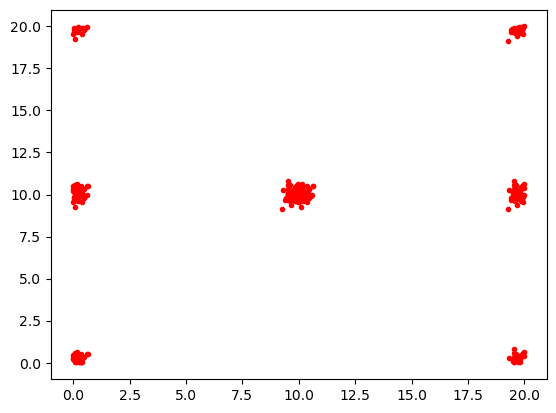

In [52]:
%pylab inline
plt.plot(particles_edge[:,0],particles_edge[:,1],"r.")

In [53]:
import numpy as np
import time
d = (1380**3/pos.shape[0])**(1/3)
st = time.time()

# Low-memory (no nbr_idx):
labels, clabels, sizes, ncl = fof.fof_clusters_grid_periodic(
    particles_edge, L=20, mode="precompute",
    b=1, max_per_cell=4, max_iters=200,
    batch_size=8192*64*2, k_iter=4
)
#fof_output_fast = fof_clusters_grid_periodic(pos[::1],jnp.array([1380,1380,1380]),max_per_cell=8,b=0.2*d*0.95,k_max=4,max_iters=200)
print(time.time()-st)


0.0032660961151123047


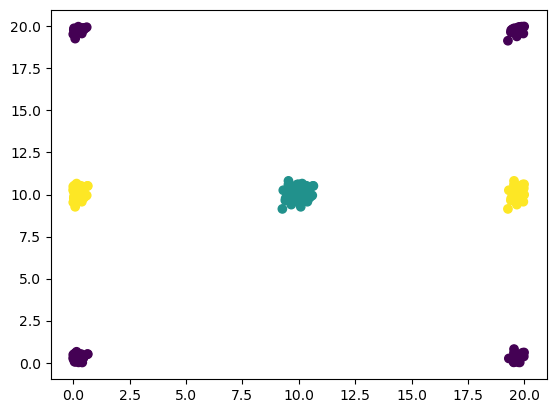

In [51]:
plt.scatter(particles_edge[:,0],particles_edge[:,1],c = clabels)

In [54]:
#running with lognormal mocks

for nn,pnum in enumerate([787121,7887677,78851677]):
    pos = np.load("./example_data/log_norm_"+str(pnum)+".npy").astype(np.float32)
    for i in range(5):
        st = time.time()
        d = (1380**3/pos.shape[0])**(1/3)
        #force fp32 & GPU placement for CUDA kernels
        pos32 = jnp.array(pos, dtype=jnp.float32, copy=True)
        pos32 = jax.device_put(pos32, jax.devices("gpu")[0])
        #some irregular behaviour with the cuda kernel, might be due to blocking...
        fof_output_fast = fof.fof_clusters_grid_periodic(
            pos32, b=float(0.2*d), L=[1380,1380,1380], k_max=int(8), max_iters=int(100)
        )
        print(pnum, i,time.time()-st)
#        del fof_output_fast
#        gc.collect()

787121 0 1.727226734161377
787121 1 1.6975984573364258
787121 2 1.6947054862976074
787121 3 1.6971263885498047
787121 4 1.6956427097320557
7887677 0 17.315635681152344
7887677 1 17.332809448242188
7887677 2 17.260011196136475
7887677 3 17.333481311798096
7887677 4 17.260776042938232


KeyboardInterrupt: 

In [ ]:
## There is also a "streaming" varient, which isn't as well tested but should have better memory performance on very large datasets

### CAMELS nbody

In [59]:
import h5py
file = h5py.File("/home/ben.horowitz/sims/camels/example_cv0/snapshot_090.hdf5.1","r")
coord = file["PartType1"]['Coordinates']
particles = coord[:][::1]
d = (25**3/particles.shape[0])**(1/3)


In [77]:
d = (25**3/particles.shape[0])**(1/3)
for i in range(1):
    st = time.time()
    out = fof.fof_clusters_grid_periodic(
            particles/1000, b=float(0.2*d), L=25, max_per_cell=4, max_iters=200,
        batch_size=8192*64*2, k_iter=4
        )
    print(particles.shape[0], i, time.time()-st)
    out[0].block_until_ready()          # if out is a JAX Array
    #Blocking is sometimes problematic... generally just for the CUDA version of the kdtree though?
    print(particles.shape[0], i, time.time() - st)
   # del out
    #L=25, max_per_cell=4, max_iters=200,
    #batch_size=8192*64*2, k_iter=4

16777216 0 184.67112565040588
16777216 0 184.76175379753113


In [78]:
out[0].shape, particles.shape

((16777216,), (16777216, 3))

In [79]:
from fof.utils import *

j_pos, j_masses = cluster_centers_masses_padded(particles/1000,out[1])
mass_filt = j_masses>5
j_masses[np.argpartition(j_masses,-4)[-4:]]

Array([293374., 325877., 341083., 710297.], dtype=float32)

In [80]:
j_masses.max()

Array(710297., dtype=float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Number')

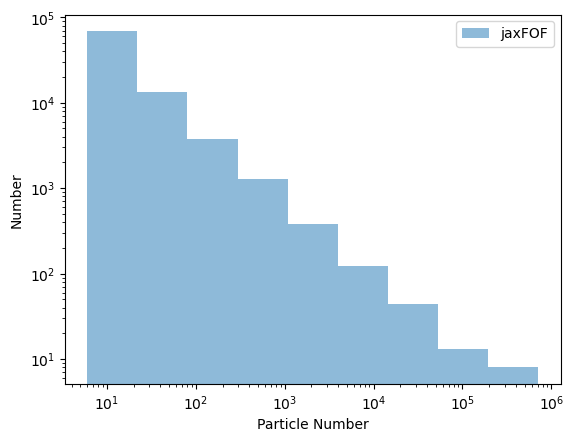

In [81]:
%pylab inline

logbins = np.logspace(np.log10((j_masses[mass_filt]).min()),np.log10((j_masses[mass_filt]).max()),10)

_,bins, _ = plt.hist(j_masses[mass_filt],alpha=0.5,bins=logbins,label="jaxFOF")
plt.loglog()
plt.legend()
plt.xlabel("Particle Number")
plt.ylabel("Number")